### Task description:
# Use two other FOXES setups (wake models) of your choice to calculate the yield again and
# plot the differences. Explain your results.

In [1]:
### approach: find out what wake models are available and how to creat them

### act like prior Tasks are done and simulate requiered variables (copy from lecture code)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV
import foxes.constants as FC

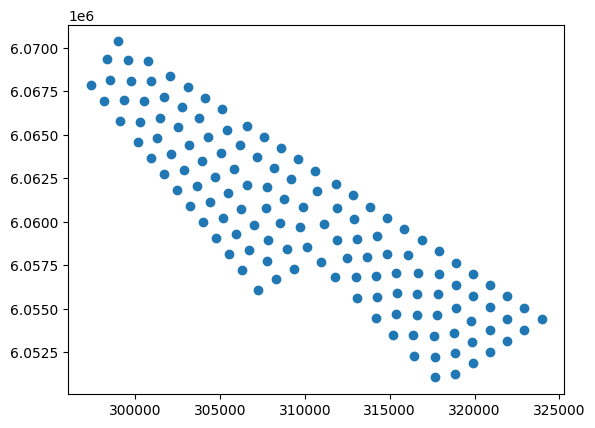

In [2]:
### explore layout data
area_geom_data = pd.read_csv('turbine-info/coordinates/area_of_interest/layout-N-10.1.geom.csv')
pos_x = np.array(area_geom_data['x'])
pos_y = np.array(area_geom_data['y'])

plt.scatter(pos_x, pos_y)
plt.show()

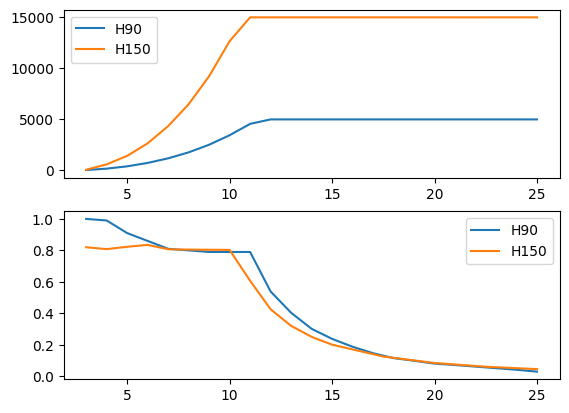

In [3]:
### explore power curve files 
higher_turbine_properties = pd.read_csv('turbine-info/power_curves/IEA-15MW-D240-H150.csv')
lower_turbine_properties = pd.read_csv('turbine-info/power_curves/NREL-5MW-D126-H90.csv')

fig, ax = plt.subplots(2,1)
ax[0].plot(lower_turbine_properties['ws'], lower_turbine_properties['P'])
ax[0].plot(higher_turbine_properties['ws'], higher_turbine_properties['P'])
ax[0].legend(['H90','H150'])

ax[1].plot(lower_turbine_properties['ws'], lower_turbine_properties['ct'])
ax[1].plot(higher_turbine_properties['ws'], higher_turbine_properties['ct'])
ax[1].legend(['H90','H150'])

In [4]:
### try to create a turbine model from given Data
mbook = foxes.models.ModelBook()

# read turbine specific performance data from one of the two options
# the turbines are of the same type as reported here: https://fraunhoferiwes.github.io/foxes.docs/notebooks/data.html#Power-and-thrust-curves
turbine_select = '90m'
if turbine_select == '150m':
    turbine_data_source = 'turbine-info/power_curves/IEA-15MW-D240-H150.csv'
elif turbine_select == '90m': 
    turbine_data_source = 'turbine-info/power_curves/NREL-5MW-D126-H90.csv'
else:
    turbine_data_source = None
    print('select a valid turbine identifier please')
    
mbook.turbine_types["my_turbine"] = foxes.models.turbine_types.PCtFile(turbine_data_source)

Turbine 0, T0: xy=(299005.80, 6070368.13), NREL5MW
Turbine 1, T1: xy=(298349.95, 6069364.01), NREL5MW
Turbine 2, T2: xy=(299546.60, 6069298.19), NREL5MW
Turbine 3, T3: xy=(300744.40, 6069255.93), NREL5MW
Turbine 4, T4: xy=(302075.57, 6068404.37), NREL5MW
Turbine 5, T5: xy=(298529.18, 6068179.05), NREL5MW
Turbine 6, T6: xy=(299725.82, 6068113.23), NREL5MW
Turbine 7, T7: xy=(300923.62, 6068070.97), NREL5MW
Turbine 8, T8: xy=(297371.96, 6067866.68), NREL5MW
Turbine 9, T9: xy=(303085.54, 6067758.28), NREL5MW
Turbine 10, T10: xy=(301715.50, 6067171.26), NREL5MW
Turbine 11, T11: xy=(304095.51, 6067112.19), NREL5MW
Turbine 12, T12: xy=(299341.24, 6066978.00), NREL5MW
Turbine 13, T13: xy=(298142.83, 6066947.93), NREL5MW
Turbine 14, T14: xy=(300539.04, 6066935.73), NREL5MW
Turbine 15, T15: xy=(302771.25, 6066601.55), NREL5MW
Turbine 16, T16: xy=(305105.47, 6066466.11), NREL5MW
Turbine 17, T17: xy=(301478.71, 6065995.11), NREL5MW
Turbine 18, T18: xy=(303781.22, 6065955.46), NREL5MW
Turbine 19, T

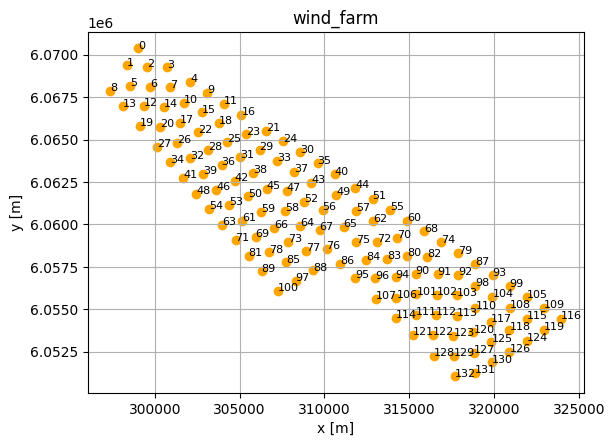

In [5]:
# setup a foxes WindFarm and implement the given data
test_farm = foxes.WindFarm(name="wind_farm")

# read layout of windfarm N10.1 and sort by position
layout_data = pd.read_csv('turbine-info/coordinates/area_of_interest/layout-N-10.1.geom.csv',index_col='Unnamed: 0').sort_values(by='y', ascending=False).reset_index(inplace=False)

# create my own turbine model (does not work yet, aparetly rho = None --> see mbook later)
#my_turbine_key = ["my_turbine"] 
# use NREL5MW instead
my_turbine_key = ["NREL5MW"]


# build layout data into foxes windFarm            
foxes.input.farm_layout.add_from_csv(test_farm,layout_data,turbine_models= my_turbine_key)
# see resulting layout
ax = foxes.output.FarmLayoutOutput(test_farm).get_figure()
plt.show()



In [6]:
# create a states data input (later given by prior tasks)
def read_ts_csv(filename):
    df = pd.read_csv(filename, parse_dates=['Unnamed: 0'])
                # data
    df.rename(columns={ df.columns[0]: "Time" }, inplace = True)
                # rename the first column to be the 'time' column
    df.drop_duplicates(subset='Time', inplace=True)

                # check for -999 and replace with NaN if applicable
    if -999 in df:
        df[df==-999] = np.nan
        
    return df
wind_data_era5 = read_ts_csv(f'reanalysis.csv')
wind_data_era5

,Time,WS100,WD100
0,1995-01-01 00:00:00,15.217,313.6
1,1995-01-01 01:00:00,16.807,311.4
2,1995-01-01 02:00:00,17.562,313.0
3,1995-01-01 03:00:00,19.496,310.7
4,1995-01-01 04:00:00,21.631,312.3
...,...,...,...
262987,2024-12-31 19:00:00,21.859,225.5
262988,2024-12-31 20:00:00,21.991,226.8
262989,2024-12-31 21:00:00,22.290,228.4
262990,2024-12-31 22:00:00,21.714,228.1


In [12]:
# cut down data amount and check for zeros
wind_data_era5.set_index('Time', inplace=True)
wind_data = wind_data_era5.loc["2006-01-01":"2006-12-31"]
wind_data

,WS100,WD100
Time,,
2006-01-01 00:00:00,8.515,243.1
2006-01-01 01:00:00,8.379,246.2
2006-01-01 02:00:00,7.772,245.6
2006-01-01 03:00:00,7.852,241.6
2006-01-01 04:00:00,8.319,239.5
...,...,...
2006-12-31 19:00:00,21.529,208.7
2006-12-31 20:00:00,21.921,204.4
2006-12-31 21:00:00,23.057,206.5


In [17]:
# select used data
wind_data = wind_data
zeros_at = wind_data.isnull()
# made up value for TI
TI_value = 0.05       # unsused so far
RHO_value = 1.225

# stock code for creating the states (does not use the yet)
my_states = foxes.input.states.Timeseries(
data_source= wind_data,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "WS100", FV.WD: "WD100"},
    fixed_vars={FV.RHO: RHO_value,FV.TI: TI_value},
)

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8760 states for 1 turbines
SingleChunkEngine: Running single chunk calculation for 8760 states


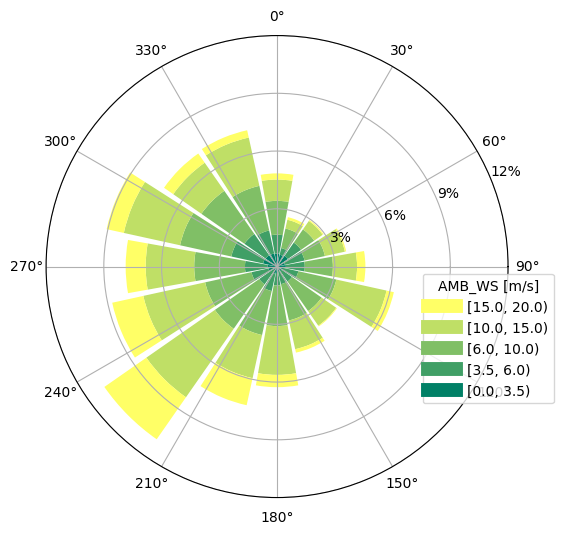

In [18]:
o = foxes.output.StatesRosePlotOutput(my_states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

In [ ]:
#mbook.print_toc()

By creating the algorithm in foxes all settings defining the simulation precedure are choosen. Here we can setup the wake models, we want to use.
If we want any other wake model, have a look into the model book and choose a different one by changing the wake models identifier to a different one from that list.

In [19]:
### this is where the wake models are choosen

my_algo = foxes.algorithms.Downwind(
    mbook =mbook,
    farm = test_farm,
    states = my_states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_quadratic_ka02", "CrespoHernandez_max_ka04"],
    verbosity=0,
)


In [21]:
my_resuls = my_algo.calc_farm(calc_parameters={"chunk_size_states": 1000})

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


In [40]:
Power_estimated = my_resuls['P'].to_numpy()

In [44]:
P_per_turbine = np.sum(Power_estimated, axis=0)
P_total = np.sum(P_per_turbine*10**-6)
print(f'The total yeild is estimated to result in {P_total/1000:.2f} GW per year')

The total yeild is estimated to result in 3.01 GW per year
